**Lesson 15 - Sentiment Analysis with Advanced Deep Learning**

Another way to supervised deep learning is the use of recurrent neural network (RNNs) and long short-term memory networks (LSTMs) which also considers the sequence of data (words, events and so on).

We leverage Keras on top of TensorFlow and try to build LSTM-based classification model and use word embeddings as our features.

# Load and normalize data

In [1]:
%run load_movie_reviews.ipynb

# Tokenize train & test datasets

Each train and test reviews are decomposed into their corresponding tokens (step 2). 

In [2]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

We have tokenized text vectors in our `tokenized_train` and `tokenized_test` variables. 

# Build Vocabulary Mapping (word to index)

For feature selection (step 3), we create word embeddings. 

We need to convert `tokenized_train` and `tokenized_test` variables into numeric representations.

You also need to create a numeric mapping for the padding term, which we will call `PAD_INDEX`, and assign it the numeric index of 0. For unknown terms, they have to be traced with some index. If a new  term comes up, we will sign it as out of vocabulary (OOV) term, assigning it to a constant index (e.g. `NOT_FOUND_INDEX` and `vocab_size+1`)

In [3]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 84663
Sample slice of vocabulary map: {'first': 11, 'thing': 12, 'strike': 13, 'brutality': 14, 'unflinche': 15, 'scene': 16, 'violence': 17, 'set': 18, 'word': 19, 'go': 20}


# Encode and Pad datasets & Encode prediction class labels

We also need the vectors to be of uniform size: you can take the length of the longest review and set it as the vector size. Let's call this `max_len`. Reviews of shorter length can be padded with a `PAD` term in the beginning to increase their length to `max_len`.

We also need to create a word of index vocabulary mapping for representing each tokenized text review in a numeric form.

In [4]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 1472
Train review vectors shape: (35000, 1472)  Test review vectors shape: (15000, 1472)


We have encoded each text review into a numeric sequence vector such that the size of each review vector is 1,442, which is basically the maximum length of reviews from the training dataset.  The shape of each review is constant.

# Build the LSTM Model Architecture

To enerate embeddings, we use the Embedding layer from Keras, which requires documents to be represented as tokenized and numeric vectors. It is coupled with the deep network architecture based on LSTMs.

print(model.summary())

We have a review with three terms: movie, was, good. We also have a vocab_map consisting of word to index mappings for 82,359 words.

The Embedding layer takes in three parameters:
1. input_dim, equal to the vocabulary size 82,358
1. output_dim, equal to 128 representing the dimension of dense emebdding
1. input_len, equal to 1,442 representing the length of the input sequences

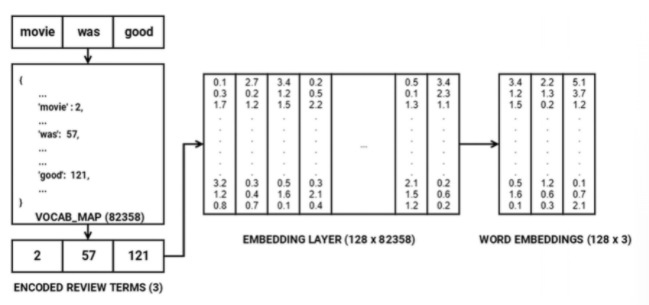

Since we have one review, the dimension is (1,3). The review is converted into a numeric sequence (2, 57,121) based on the VOCAB_MAP. Then the specific columns representing the indices in the review sequence are selected from the embedding layer to generate the final word embeddings. This gives us an embedding vector of dimension (1, 128, 3).

The weights in the embedding layer are updated and optimized in each epoch based on the input data when propagated through the whole network.

These dense word emebeddings are then passed to the LSTM layer having 64 units.

The basic architercture of RNN and LSTM.

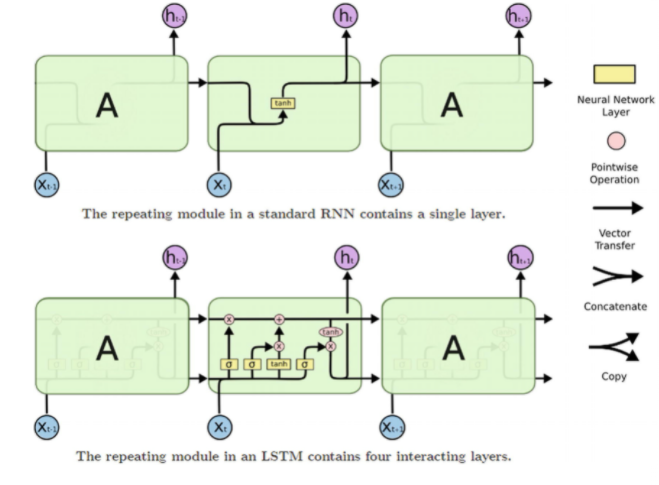

RNN usually have a chain of repeating modules so that the module has a simple structure of maybe one layer with the tanh activation. 

LSTM are also special type of RNN, with a similar structure, but the LSTM unit has four neural network layers instead of just one.

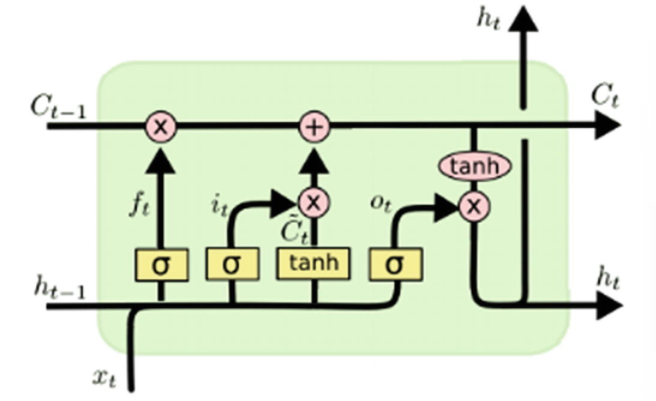

The notation `t` indicates one time step, `C` depicts the cell states, and `h` indicates the hidden states. The gates i, f, o and Ct tilde help remove or add information to the cell state.  The gates i, f, and o represent the input, output and forget gates. Each of them is modulated by the sigmoid layer, which outputs numbers from 0 to 1. 

The detailed workflow of how information flows through the LSTM cell is characterized by four steps:
1. the gate layer f helps us decide what information we should throw away from the cell state
1. the gate layer i helps decide what information will be stored in the current cell state
1. the third step involves updating the old cell state Ct-1 to the new cell state Ct
1. the fourth and final step helps us decide the final output 

The final layer is the Dense layer with 1 unit and the sigmoid activation function.

# Visualize model architecture

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=65).create(prog='dot', format='svg'))

# Train the model

We train our model on the training data with five epochs, batch size of 100 reviews, and a 10% validation split of training data to measure validation accuracy.

**The below operation requires more than 2 hours.**

batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train the model LSTM on CPU is quite slow. You can try to use colab service with GPU resource.

# Predict and Evaluate Model Performance

Let's see how well it predicts the sentiment for our test reviws and use the same model evaluation framework we used in our previous models (step 5).

pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])  

We obtained a model accuracy and F1-score of 88%. With better data, we can obtain a better score.